# Tutorial Test

Running tutorial codes for model building [link](https://www.nishika.com/competitions/32/topics/310)

本コンペは日次の野菜卸売価格の予測タスクですが、ここでは簡単のため、月次の予測タスクに読み替えてみます（日毎に予測値は変えない）<br>
本notebookでは学習・推論を行います。前のnotebookで前処理を行った後、実行してください

In [1]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font="IPAexGothic")
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
plt.rcParams['font.family'] = "MS Gothic" # Use this font to avoid encoding error
import os

In [2]:
def root_mean_squared_percentage_error(true_y, pred_y):
    return np.sqrt(np.mean(((pred_y - true_y) / true_y)**2))*100

まずはデータの概要を把握します

In [3]:
train_df = pd.read_csv('../data/preprocessed_train.csv')
print(train_df.shape)
train_df

(97782, 5)


,kind,date,amount,mode_price,area
0,だいこん,20051107,201445.0,735.0,千葉
1,だいこん,20051108,189660.0,840.0,千葉_全国_青森
2,だいこん,20051110,218166.0,735.0,千葉_全国_青森
3,だいこん,20051111,182624.0,682.5,千葉_青森
4,だいこん,20051112,220691.0,682.5,千葉_青森
...,...,...,...,...,...
97777,しめじ,20170526,17231.0,48.5,新潟_長野
97778,しめじ,20170527,17105.0,48.5,新潟_長野
97779,しめじ,20170529,12406.0,48.5,新潟_長野
97780,しめじ,20170530,12320.0,48.5,新潟_長野


In [4]:
test_df = pd.read_csv('../data/preprocessed_test.csv')
print(test_df.shape)
test_df

(320, 5)


,kind,date,amount,mode_price,area
0,だいこん,20220502,NaN,NaN,千葉_全国_青森
1,だいこん,20220506,NaN,NaN,千葉_全国_青森
2,だいこん,20220507,NaN,NaN,千葉_全国_青森
3,だいこん,20220509,NaN,NaN,千葉_全国_青森
4,だいこん,20220510,NaN,NaN,千葉_全国_青森
...,...,...,...,...,...
315,ミニトマト,20220526,NaN,NaN,全国_名古屋
316,ミニトマト,20220527,NaN,NaN,全国_名古屋
317,ミニトマト,20220528,NaN,NaN,全国_名古屋
318,ミニトマト,20220530,NaN,NaN,全国_名古屋


この後月次で値を見ていくので、年・月のカラムを新たに作成しておきます

In [5]:
train_df['year'] = train_df['date']//10000
test_df['year'] = test_df['date']//10000
train_df['month'] = train_df['date'].apply(lambda x: int(str(x)[4:6]))
test_df['month'] = test_df['date'].apply(lambda x: int(str(x)[4:6]))

連続変数のカラムについて、基本統計量を確認します

In [6]:
train_df.describe()

,date,amount,mode_price,year,month
count,9.778200e+04,97782.000000,97782.000000,97782.000000,97782.000000
mean,2.013619e+07,87095.257246,1341.207081,2013.550889,6.604784
std,4.726274e+04,84438.195701,1304.031597,4.728611,3.481086
min,2.005111e+07,1.000000,18.500000,2005.000000,1.000000
25%,2.009123e+07,21664.250000,227.000000,2009.000000,4.000000
50%,2.014012e+07,58335.500000,1242.000000,2014.000000,7.000000
75%,2.018020e+07,128100.750000,1890.000000,2018.000000,10.000000
max,2.022043e+07,965216.000000,25920.000000,2022.000000,12.000000


In [7]:
test_df.describe()

,date,amount,mode_price,year,month
count,3.200000e+02,0.0,0.0,320.0,320.0
mean,2.022052e+07,NaN,NaN,2022.0,5.0
std,8.318880e+00,NaN,NaN,0.0,0.0
min,2.022050e+07,NaN,NaN,2022.0,5.0
25%,2.022051e+07,NaN,NaN,2022.0,5.0
50%,2.022052e+07,NaN,NaN,2022.0,5.0
75%,2.022052e+07,NaN,NaN,2022.0,5.0
max,2.022053e+07,NaN,NaN,2022.0,5.0


trainデータの期間は2005年11月から2022年4月まで、testデータの期間は2022年の5月のみになっています

目的変数についてもう少し分析します。野菜種別ごとにどうなっているか確認します

In [8]:
TARGET = 'mode_price'

In [9]:
train_df.groupby('kind')[[TARGET]].mean().sort_values(by=TARGET, ascending=False)

,mode_price
kind,
まつたけ,11958.579545
うめ,4260.568768
たけのこ,3352.057112
さといも,3111.933740
ピース,2728.024752
セルリー,2584.674411
たまねぎ,2407.175344
かぼちゃ,2360.578858
じゃがいも,2096.550217


野菜ごとに大きく価格は異なっています。<br>
従って、野菜種別は説明変数に入れるべき、ないし野菜ごとにモデルを作るべき、と考えます

train, testに入っている野菜種別を見てみます

In [10]:
train_df['kind'].unique(), test_df['kind'].unique()

(array(['だいこん', 'かぶ', 'にんじん', 'ごぼう', 'れんこん', 'キャベツ', 'レタス', 'はくさい', 'こまつな',
        'ほうれんそう', 'ねぎ', 'しゅんぎく', 'ブロッコリー', 'きゅうり', 'かぼちゃ', 'なす', 'トマト',
        'ピーマン', 'じゃがいも', 'さつまいも', 'さといも', 'たまねぎ', 'なましいたけ', 'セルリー',
        'さやえんどう', 'なのはな', 'たけのこ', 'ふき', 'うど', 'そらまめ', 'アスパラガス', 'ピース',
        'とうもろこし', 'いんげん', 'えだまめ', 'うめ', 'まつたけ', 'オクラ', 'レイシにがうり', 'みずな',
        'ミニトマト', 'にら', 'えのきだけ', 'しめじ'], dtype=object),
 array(['だいこん', 'にんじん', 'キャベツ', 'レタス', 'はくさい', 'こまつな', 'ほうれんそう', 'ねぎ',
        'きゅうり', 'トマト', 'ピーマン', 'じゃがいも', 'なましいたけ', 'セルリー', 'そらまめ', 'ミニトマト'],
       dtype=object))

In [11]:
len(train_df['kind'].unique()), len(test_df['kind'].unique())

(44, 16)

trainにしかない野菜種別が多く存在します。<br>
今回は野菜種別が重要な説明変数と考えるので、trainにしかない野菜種別は除いて学習することとします

In [12]:
kinds = test_df['kind'].unique()
train_df = train_df[train_df['kind'].isin(kinds)]
print(train_df.shape)
train_df

(61064, 7)


,kind,date,amount,mode_price,area,year,month
0,だいこん,20051107,201445.0,735.0,千葉,2005,11
1,だいこん,20051108,189660.0,840.0,千葉_全国_青森,2005,11
2,だいこん,20051110,218166.0,735.0,千葉_全国_青森,2005,11
3,だいこん,20051111,182624.0,682.5,千葉_青森,2005,11
4,だいこん,20051112,220691.0,682.5,千葉_青森,2005,11
...,...,...,...,...,...,...,...
97582,ミニトマト,20220425,71421.0,108.0,全国_名古屋,2022,4
97583,ミニトマト,20220426,34631.0,108.0,全国_名古屋,2022,4
97584,ミニトマト,20220428,74221.0,108.0,全国_名古屋,2022,4
97585,ミニトマト,20220429,39556.0,108.0,全国_名古屋,2022,4


データを見ると、必ずしも毎日レコードがあるわけではありません。レコードが存在する日数を種類別・月別にカウントしてみます

In [13]:
pd.pivot_table(train_df.query('20210501 <= date <= 20220430'), index='kind', columns='month', values=TARGET, aggfunc='count')

month,1,2,3,4,5,6,7,8,9,10,11,12
kind,,,,,,,,,,,,
きゅうり,20.0,20.0,22.0,22.0,21.0,21.0,23.0,20.0,20.0,22.0,22.0,21.0
こまつな,20.0,20.0,22.0,22.0,21.0,21.0,23.0,20.0,20.0,22.0,22.0,20.0
じゃがいも,20.0,20.0,22.0,22.0,21.0,21.0,23.0,20.0,20.0,22.0,22.0,21.0
そらまめ,NaN,NaN,NaN,22.0,21.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
だいこん,20.0,20.0,22.0,22.0,21.0,21.0,23.0,20.0,20.0,22.0,22.0,21.0
なましいたけ,20.0,20.0,22.0,22.0,21.0,NaN,NaN,NaN,20.0,22.0,22.0,21.0
にんじん,20.0,20.0,22.0,22.0,21.0,21.0,23.0,20.0,20.0,22.0,22.0,21.0
ねぎ,20.0,20.0,22.0,22.0,21.0,21.0,23.0,20.0,20.0,22.0,22.0,21.0
はくさい,20.0,20.0,22.0,22.0,21.0,21.0,23.0,20.0,20.0,22.0,22.0,21.0


全ての野菜について、レコード数は月に20日強にとどまっています。<br>
つまり、取引が行われていない日があります。市場に野菜が出ていない可能性もありますが、全ての野菜について取引が行われていない場合、市場自体が空いていないと考えられます

卸売価格の推移をグラフに描画してみます

In [14]:
all_df = pd.concat([train_df, test_df]).reset_index(drop=True)

取引のない日のレコード分ダミーデータを作成して、綺麗に可視化されるようにします

In [15]:
max_days = (datetime(2022, 12, 31) - datetime(2005, 1, 1)).days

dum_data = []

for i in range(max_days+1):
    date = datetime(2005, 1, 1) + timedelta(days=i)
    y, wn = date.isocalendar()[0], date.isocalendar()[1]
    date = int(date.strftime('%Y%m%d'))
    m = int(str(date)[4:6])
    dum_data.append(['ダミー', date, 0, 0, 'ダミー', y, m])

dum_df = pd.DataFrame(dum_data, columns=all_df.columns)
dum_df.head()

,kind,date,amount,mode_price,area,year,month
0,ダミー,20050101,0,0,ダミー,2004,1
1,ダミー,20050102,0,0,ダミー,2004,1
2,ダミー,20050103,0,0,ダミー,2005,1
3,ダミー,20050104,0,0,ダミー,2005,1
4,ダミー,20050105,0,0,ダミー,2005,1


In [16]:
vis_df = pd.concat([all_df, dum_df])
vis_df = vis_df.query('20160601 <= date <= 20220531').reset_index(drop=True)
vis_df = pd.pivot_table(vis_df, index='date', columns='kind', values='mode_price').reset_index()
vis_df.fillna(0, inplace=True)
vis_df.head()

kind,date,きゅうり,こまつな,じゃがいも,そらまめ,だいこん,なましいたけ,にんじん,ねぎ,はくさい,ほうれんそう,キャベツ,セルリー,ダミー,トマト,ピーマン,ミニトマト,レタス
0,20160601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20160602,1080.0,210.5,2268.0,1512.0,864.0,0.0,1512.0,2376.0,1350.0,91.5,864.0,0.0,0.0,972.0,54.0,119.0,1296.0
2,20160603,1188.0,140.5,2376.0,1512.0,864.0,0.0,1404.0,2268.0,1215.0,86.0,756.0,0.0,0.0,918.0,51.5,140.5,1296.0
3,20160604,1188.0,151.0,2754.0,1512.0,756.0,0.0,1404.0,2592.0,1404.0,81.0,756.0,0.0,0.0,972.0,65.0,140.5,1404.0
4,20160605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


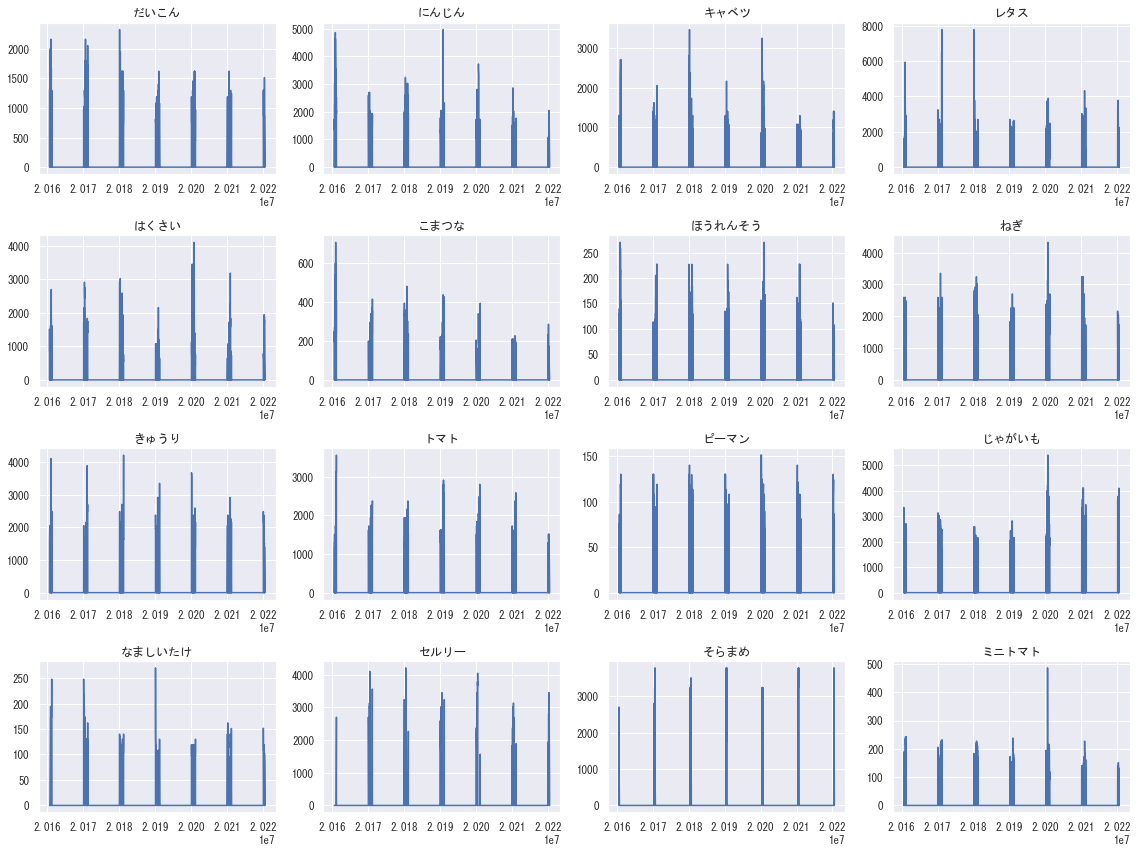

In [17]:
nrow = 4
ncol = 4

fig, ax = plt.subplots(nrow, ncol, figsize=(16, 12))
for i, kind in enumerate(kinds):
    if i < nrow*ncol:
        df = vis_df.loc[:,['date',kind]]
        df.columns = ['date', TARGET]
        j = i//ncol
        k = i%ncol
        ax[j, k].plot(df['date'].to_list(), df[TARGET].to_list())
        ax[j, k].set_title(kind)
plt.tight_layout()
plt.show()
plt.close()

多くの野菜で年によって価格が大きく異なることがわかります。そのため：

- ある月の価格は、前年の価格より前月など直近の価格に近いものになっていると思われる
- 各年の価格の先行指標となる変数を探す必要がある

と言えそうです。<br>
価格の先行指標として、ここでは天候データを使ってみます。卸売価格データと結合します

In [18]:
have_data_combs = [list(i) for i in all_df[['kind','year','month']].drop_duplicates().values]
have_data_combs[:5]

dum_data = []

for kind in kinds:
    for year in range(2005, 2023):
        for month in range(1,13):
            if year < 2022 or (year == 2022 and month < 5):
                if [kind, year, month] not in have_data_combs:
                    date = year*10000+month*100+99
                    dum_data.append([kind,date,0,0,'全国',year, month])

dum_df = pd.DataFrame(dum_data, columns=all_df.columns)
dum_df.head()

,kind,date,amount,mode_price,area,year,month
0,だいこん,20050199,0,0,全国,2005,1
1,だいこん,20050299,0,0,全国,2005,2
2,だいこん,20050399,0,0,全国,2005,3
3,だいこん,20050499,0,0,全国,2005,4
4,だいこん,20050599,0,0,全国,2005,5


In [19]:
all_df = pd.concat([all_df, dum_df]).reset_index(drop=True)
all_df.head()

,kind,date,amount,mode_price,area,year,month
0,だいこん,20051107,201445.0,735.0,千葉,2005,11
1,だいこん,20051108,189660.0,840.0,千葉_全国_青森,2005,11
2,だいこん,20051110,218166.0,735.0,千葉_全国_青森,2005,11
3,だいこん,20051111,182624.0,682.5,千葉_青森,2005,11
4,だいこん,20051112,220691.0,682.5,千葉_青森,2005,11


In [20]:
wea_df = pd.read_csv('../data/preprocessed_weather.csv')
print(wea_df.shape)
wea_df

(50820, 21)


,year,month,mean_mean_temp,max_mean_temp,min_mean_temp,mean_max_temp,max_max_temp,min_max_temp,mean_min_temp,max_min_temp,...,mean_sum_rain,max_sum_rain,min_sum_rain,mean_sun_time,max_sun_time,min_sun_time,mean_mean_humid,max_mean_humid,min_mean_humid,area
0,2004.0,11.0,14.596000,19.30,9.60,18.340000,22.20,12.40,11.228000,17.40,...,5.840000,87.00,0.0,5.084000,9.50,0.0,71.760000,93.0,43.0,千葉
1,2004.0,12.0,9.641935,19.00,2.20,13.564516,24.30,3.80,6.138710,11.50,...,2.435484,26.00,0.0,5.509677,9.40,0.0,58.612903,86.0,37.0,千葉
2,2005.0,1.0,6.277419,13.10,3.10,10.461290,17.20,5.20,2.522581,6.40,...,3.338710,66.50,0.0,6.612903,9.80,0.0,54.838710,89.0,32.0,千葉
3,2005.0,2.0,5.960714,12.00,3.30,9.864286,15.40,5.10,2.060714,4.60,...,1.910714,11.50,0.0,5.225000,9.70,0.0,55.714286,93.0,31.0,千葉
4,2005.0,3.0,8.800000,13.70,1.60,13.122581,18.40,3.60,4.596774,10.00,...,2.612903,22.50,0.0,5.529032,11.30,0.0,59.129032,91.0,31.0,千葉
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50815,2021.0,12.0,3.674194,9.50,-2.35,7.722581,14.60,-0.65,0.106452,6.75,...,6.064516,35.25,0.0,3.033871,8.55,0.0,82.064516,97.5,63.5,新潟_長野
50816,2022.0,1.0,0.517742,4.20,-2.00,3.796774,8.20,0.80,-2.572581,1.65,...,2.669355,16.75,0.0,3.366129,8.35,0.0,78.548387,93.0,63.5,新潟_長野
50817,2022.0,2.0,0.883929,4.55,-1.80,4.471429,10.85,-0.50,-2.244643,0.45,...,2.758929,17.00,0.0,3.326786,8.35,0.0,77.892857,92.5,63.0,新潟_長野
50818,2022.0,3.0,6.453226,13.40,1.35,11.838710,19.60,4.55,1.927419,9.55,...,2.137097,21.25,0.0,5.272581,10.65,0.0,70.790323,90.5,53.0,新潟_長野


ラグ特徴量を作ります。以下では1,2,3,6,9,12ヶ月前の天候を特徴量としています

In [21]:
def add_weather_feat(all_df, nshift):

    mer_wea_df = wea_df.copy()
    mer_wea_df.columns = [f'{i}_{nshift}prev' if i not in ['year','month','area'] else i for i in mer_wea_df.columns]
    mer_wea_df = mer_wea_df.rename(columns={'year':'merge_year','month':'merge_month'})

    data = []

    for year, month in zip(all_df['year'].values, all_df['month'].values):
        month -= nshift
        if month <= 0:
            month += 12
            year -=1
        data.append([year, month])

    tmp_df = pd.DataFrame(data, columns=['merge_year','merge_month'])

    mer_df = pd.concat([all_df, tmp_df],axis=1)

    mer_df = pd.merge(mer_df, mer_wea_df, on=['merge_year','merge_month','area'], how='left')
    mer_df.drop(['merge_year', 'merge_month'], axis=1, inplace=True)

    return mer_df


mer_df = all_df.copy()

for nshift in [1,2,3,6,9,12]:
    mer_df = add_weather_feat(mer_df, nshift)

print(mer_df.shape)
mer_df.head()

(61945, 115)


,kind,date,amount,mode_price,area,year,month,mean_mean_temp_1prev,max_mean_temp_1prev,min_mean_temp_1prev,...,min_min_temp_12prev,mean_sum_rain_12prev,max_sum_rain_12prev,min_sum_rain_12prev,mean_sun_time_12prev,max_sun_time_12prev,min_sun_time_12prev,mean_mean_humid_12prev,max_mean_humid_12prev,min_mean_humid_12prev
0,だいこん,20051107,201445.0,735.0,千葉,2005,11,18.838710,24.70000,13.400000,...,6.4000,5.840000,87.000000,0.0,5.084000,9.500000,0.0,71.760000,93.000000,43.000000
1,だいこん,20051108,189660.0,840.0,千葉_全国_青森,2005,11,17.103797,22.54375,11.726042,...,3.5625,3.898958,47.526042,0.0,4.323542,9.292708,0.0,69.999167,89.989583,48.197917
2,だいこん,20051110,218166.0,735.0,千葉_全国_青森,2005,11,17.103797,22.54375,11.726042,...,3.5625,3.898958,47.526042,0.0,4.323542,9.292708,0.0,69.999167,89.989583,48.197917
3,だいこん,20051111,182624.0,682.5,千葉_青森,2005,11,16.454839,21.85000,11.150000,...,3.2000,4.120000,50.000000,0.0,3.762000,9.200000,0.0,71.060000,91.000000,47.500000
4,だいこん,20051112,220691.0,682.5,千葉_青森,2005,11,16.454839,21.85000,11.150000,...,3.2000,4.120000,50.000000,0.0,3.762000,9.200000,0.0,71.060000,91.000000,47.500000


目的変数と天候データ系変数の相関を確認します

In [22]:
agg_cols = [i for i in mer_df.columns if i not in ['kind','date','year','weekno','area','month','amount']]

for kind in mer_df.kind.unique():
    ext_df = mer_df[mer_df['kind'] == kind]
    gb_df = ext_df.groupby(['year','month'])[agg_cols].mean()
    cor_df = gb_df.corr()
    print(kind)
    display(cor_df.query(f'0.5 <= {TARGET} < 1')[[TARGET]].sort_values(by=TARGET, ascending=False))

だいこん


,mode_price


にんじん


,mode_price


キャベツ


,mode_price


レタス


,mode_price
min_min_temp_6prev,0.601621
min_mean_temp_6prev,0.589316
min_max_temp_6prev,0.585588
mean_min_temp_6prev,0.584855
mean_max_temp_6prev,0.581500
mean_mean_temp_6prev,0.581434
max_max_temp_6prev,0.568012
max_min_temp_6prev,0.565794
max_mean_temp_6prev,0.564145
max_sun_time_6prev,0.538373


はくさい


,mode_price


こまつな


,mode_price


ほうれんそう


,mode_price


ねぎ


,mode_price


きゅうり


,mode_price
max_sun_time_6prev,0.576743
min_min_temp_6prev,0.511198
min_mean_temp_6prev,0.501006


トマト


,mode_price
max_sun_time_6prev,0.516934


ピーマン


,mode_price
min_min_temp_6prev,0.587383
min_mean_temp_6prev,0.579129
min_mean_humid_6prev,0.578364
mean_min_temp_6prev,0.571440
mean_mean_humid_6prev,0.570244
min_max_temp_6prev,0.568406
mean_mean_temp_6prev,0.562371
mean_max_temp_6prev,0.553089
max_min_temp_6prev,0.539290
max_sun_time_9prev,0.538936


じゃがいも


,mode_price


なましいたけ


,mode_price
min_mean_humid_3prev,0.640420
mean_mean_humid_3prev,0.608723
max_sun_time_6prev,0.581213
max_max_temp_6prev,0.552744
mean_max_temp_6prev,0.541807
mean_mean_temp_6prev,0.532039
max_mean_temp_6prev,0.531854
max_min_temp_6prev,0.523505
mean_min_temp_6prev,0.515880
min_mean_temp_6prev,0.507325


セルリー


,mode_price
max_sun_time_9prev,0.838200
mean_mean_humid_6prev,0.692463
max_min_temp_6prev,0.680831
mean_min_temp_6prev,0.677675
min_max_temp_6prev,0.669321
min_min_temp_6prev,0.669057
min_mean_temp_6prev,0.665666
mean_mean_temp_6prev,0.665588
mean_max_temp_6prev,0.654407
min_mean_humid_6prev,0.652919


そらまめ


,mode_price
min_mean_humid_9prev,0.759133
min_min_temp_9prev,0.751656
mean_min_temp_9prev,0.735372
min_mean_temp_9prev,0.728373
min_max_temp_9prev,0.718337
mean_mean_temp_9prev,0.716712
max_min_temp_9prev,0.702716
mean_max_temp_9prev,0.696684
max_mean_temp_9prev,0.686838
mean_mean_humid_9prev,0.678402


ミニトマト


,mode_price


野菜の種類によりますが、目的変数に対して相関係数0.5以上の天候データ系変数がある野菜もあり、一定の説明力が期待できます

予測モデルを構築します。<br>
LightGBMを使用します。比較のため、前月の値をそのまま予測値としたルールベースモデルも構築します

また、目的変数自身の1,2,3,6,9,12ヶ月前の値もラグ特徴量として取り入れます

In [23]:
SEED = 0

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

In [24]:
# ルールベースの予測値

result = []

for kind in kinds:
    ext_df = mer_df[mer_df['kind'] == kind]
    gb_df = ext_df.groupby(['year','month'])[TARGET].mean().reset_index()
    gb_df[f'{TARGET}_1prev'] = gb_df[TARGET].shift(1)
    prev_value = gb_df.query('year==2022 & month==5')[f'{TARGET}_1prev'].values[0]
    result.append([kind,2022,5,prev_value])

result_df = pd.DataFrame(result, columns=['kind','year','month',TARGET])

sub_df = pd.read_csv('../data/sample_submission.csv')
sub_df.drop(TARGET, axis=1, inplace=True)
sub_df['year'] = sub_df['date'].apply(lambda x: int(str(x)[:4]))
sub_df['month'] = sub_df['date'].apply(lambda x: int(str(x)[4:6]))
sub_df = pd.merge(sub_df, result_df, on=['kind','year','month'], how='left')
sub_df.drop(['year','month'], axis=1, inplace=True)

rule_sub_df = sub_df.copy()
rule_sub_df.columns = ['kind', 'date', f'rule_{TARGET}']
rule_sub_df.head()

,kind,date,rule_mode_price
0,だいこん,20220502,967.090909
1,だいこん,20220506,967.090909
2,だいこん,20220507,967.090909
3,だいこん,20220509,967.090909
4,だいこん,20220510,967.090909


In [25]:
# モデルベースの予測値

result = []
model_dict = {}
pred_df_dict = {}
feature_imp_dict = {}
tra_df_dict = {}

for kind in kinds:
    
    print(kind)
    ext_df = mer_df[mer_df['kind'] == kind]
    gb_df = ext_df.groupby(['year','month'])[agg_cols].mean().reset_index()
    gb_df[TARGET] = gb_df[TARGET].replace(0,np.nan)

    # 過去の値を特徴量とする
    for i in [1,2,3,6,9,12]:
        gb_df[f'{TARGET}_{i}prev'] = gb_df[TARGET].shift(i)

    test_df = gb_df.query('year == 2022 & month == 5')
    train_df = gb_df.query('~(year == 2022 & month == 5)')
    train_df = train_df.query('year >= 2018') # 2018年以降のデータで学習
    train_df = train_df[train_df[TARGET].notnull()]

    cat_cols = []
    num_cols = [i for i in train_df.columns if i not in [TARGET, 'year', 'month', 'index', 'amount']]
    feat_cols = cat_cols + num_cols

    all_df = pd.concat([train_df, test_df])
    all_df[feat_cols] = all_df[feat_cols].fillna(method='bfill')
    all_df[feat_cols] = all_df[feat_cols].fillna(method='ffill')
    all_df[feat_cols] = all_df[feat_cols].fillna(0)
    train_df = all_df.iloc[:-1,:]
    test_df = all_df.iloc[-1:,:]
    
    # バリデーションはHold-out法（一定割合で学習データと評価データの2つに分割）で行う

    tra_df = train_df.iloc[:-1]
    val_df = train_df.iloc[-1:] # 2022年4月のデータでvalidation

    tra_x = tra_df[feat_cols]
    tra_y = tra_df[TARGET]
    val_x = val_df[feat_cols]
    val_y = val_df[TARGET]
    test_x = test_df[feat_cols]
    test_y = test_df[TARGET]

    tra_data = lgb.Dataset(tra_x, label=tra_y)
    val_data = lgb.Dataset(val_x, label=val_y)

    model = lgb.train(
        params,
        tra_data, 
        categorical_feature = cat_cols,
        valid_names = ['train', 'valid'],
        valid_sets =[tra_data, val_data], 
        verbose_eval = 100,
    )

    val_pred = model.predict(val_x, num_iteration=model.best_iteration)

    pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), tra_x.columns)), columns=['importance', 'feature'])

    test_pred = model.predict(test_x, num_iteration=model.best_iteration)

    result.append([kind,2022,5,test_pred[0]])
    model_dict[kind] = model
    pred_df_dict[kind] = pred_df
    feature_imp_dict[kind] = feature_imp
    tra_df_dict[kind] = tra_df

だいこん
Training until validation scores don't improve for 100 rounds


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	train's rmse: 40.5937	valid's rmse: 48.4442
Early stopping, best iteration is:
[1]	train's rmse: 249.304	valid's rmse: 32.4025
にんじん


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 79.8487	valid's rmse: 35.3452
Early stopping, best iteration is:
[17]	train's rmse: 254.972	valid's rmse: 0.0154404
キャベツ


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 83.019	valid's rmse: 108.478
[200]	train's rmse: 37.5305	valid's rmse: 128.574
Early stopping, best iteration is:
[108]	train's rmse: 78.1012	valid's rmse: 106.02
レタス


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 144.616	valid's rmse: 181.646
Early stopping, best iteration is:
[11]	train's rmse: 505.124	valid's rmse: 155.784
はくさい


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 69.613	valid's rmse: 186.531
Early stopping, best iteration is:
[13]	train's rmse: 349.904	valid's rmse: 5.2335
こまつな


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.10061	valid's rmse: 14.2507
Early stopping, best iteration is:
[19]	train's rmse: 24.4931	valid's rmse: 0.355072
ほうれんそう


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 3.14386	valid's rmse: 5.5207
Early stopping, best iteration is:
[16]	train's rmse: 18.3789	valid's rmse: 0.0187507
ねぎ


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 40.3752	valid's rmse: 39.5214
Early stopping, best iteration is:
[46]	train's rmse: 119.829	valid's rmse: 34.1424
きゅうり


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 41.6119	valid's rmse: 212.947
Early stopping, best iteration is:
[20]	train's rmse: 208.209	valid's rmse: 1.64793
トマト


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 26.6903	valid's rmse: 195.23
Early stopping, best iteration is:
[11]	train's rmse: 224.472	valid's rmse: 3.70532
ピーマン


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.29594	valid's rmse: 11.6312
Early stopping, best iteration is:
[1]	train's rmse: 17.6264	valid's rmse: 8.72583
じゃがいも


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 104.764	valid's rmse: 157.372
Early stopping, best iteration is:
[34]	train's rmse: 233.558	valid's rmse: 5.75799
なましいたけ


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 3.18198	valid's rmse: 8.46455
[200]	train's rmse: 1.52864	valid's rmse: 7.52682
[300]	train's rmse: 0.74769	valid's rmse: 7.08287
[400]	train's rmse: 0.385169	valid's rmse: 6.98344
[500]	train's rmse: 0.204835	valid's rmse: 6.93307
[600]	train's rmse: 0.114381	valid's rmse: 6.91955
[700]	train's rmse: 0.0678584	valid's rmse: 6.90755
[800]	train's rmse: 0.0428343	valid's rmse: 6.89579
[900]	train's rmse: 0.0300024	valid's rmse: 6.89462
[1000]	train's rmse: 0.023867	valid's rmse: 6.89386
Early stopping, best iteration is:
[961]	train's rmse: 0.0257168	valid's rmse: 6.89364
セルリー


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 42.2639	valid's rmse: 148.321
Early stopping, best iteration is:
[16]	train's rmse: 283.181	valid's rmse: 5.52428
そらまめ


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 56.8648	valid's rmse: 553.077
Early stopping, best iteration is:
[2]	train's rmse: 276.094	valid's rmse: 367.097
ミニトマト


c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\ProgramData\Anaconda3\envs\vege_comp\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 3.02726	valid's rmse: 0.0779952
[200]	train's rmse: 1.30441	valid's rmse: 0.053397
Early stopping, best iteration is:
[113]	train's rmse: 2.66731	valid's rmse: 0.00339986


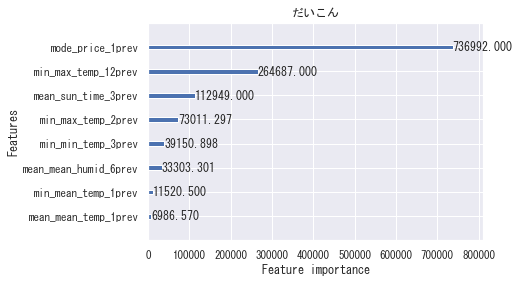

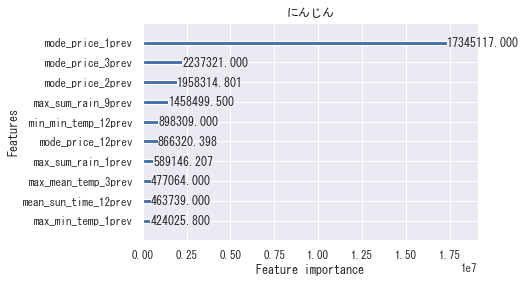

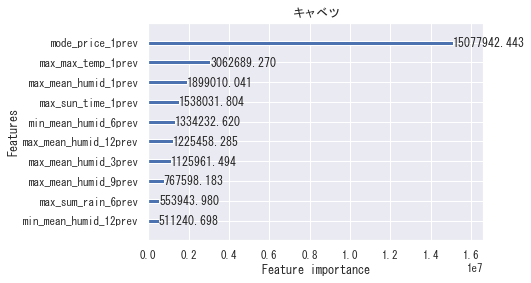

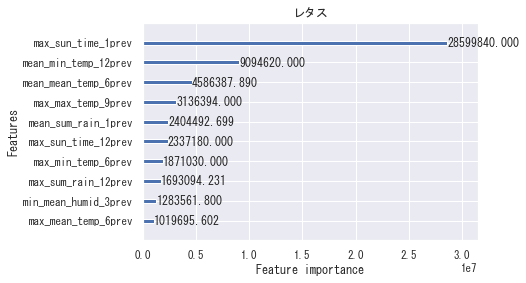

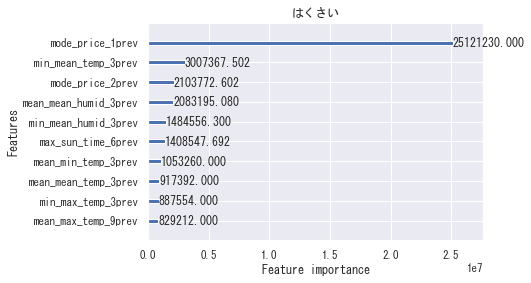

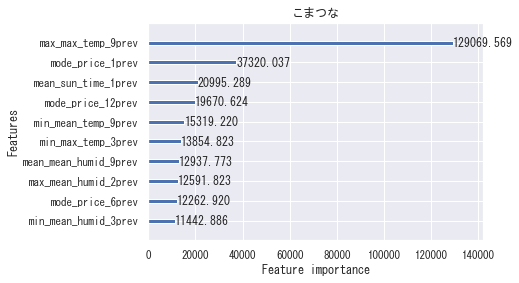

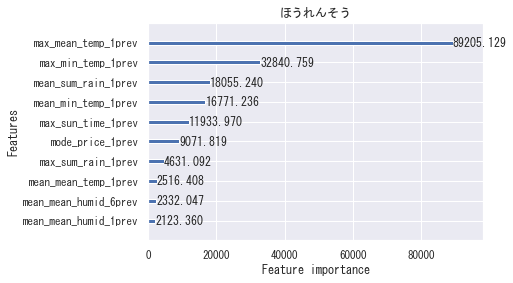

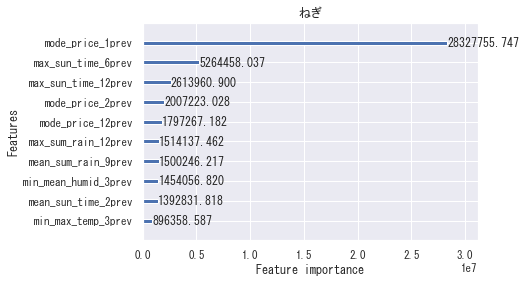

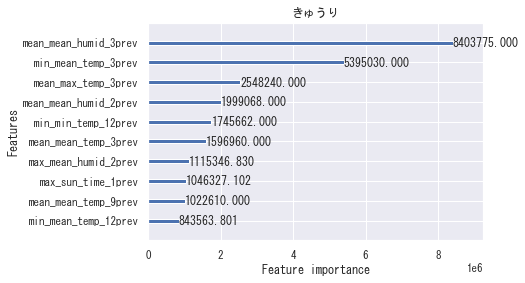

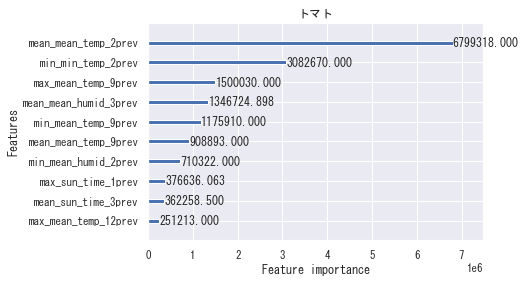

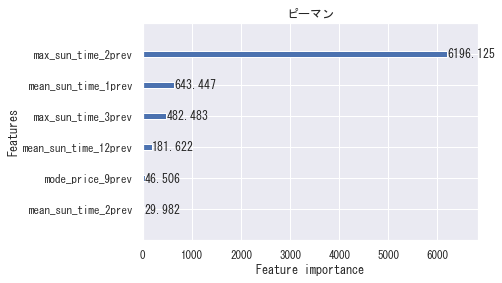

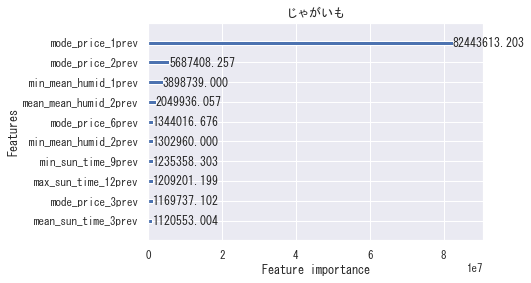

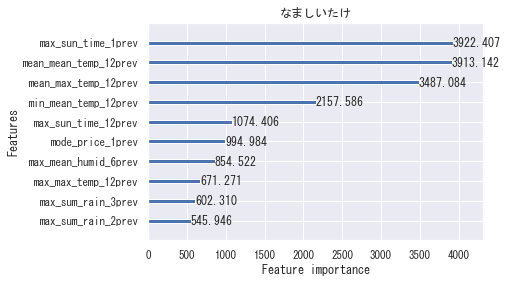

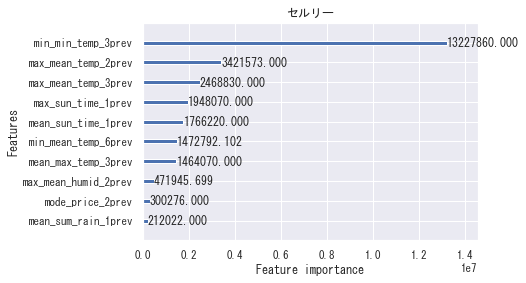

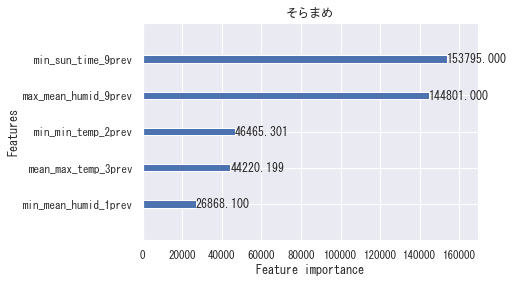

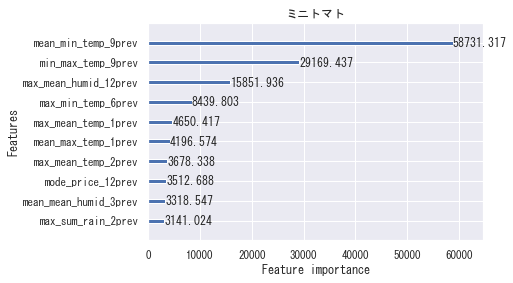

In [26]:
for kind in kinds:
    model = model_dict[kind]
    lgb.plot_importance(model, figsize=(6,4), max_num_features=10, importance_type='gain', title=kind)
plt.show()
plt.close()

submissionファイルを作成します

In [27]:
result_df = pd.DataFrame(result, columns=['kind','year','month',TARGET])

sub_df = pd.read_csv('../data/sample_submission.csv')
sub_df.drop(TARGET, axis=1, inplace=True)
sub_df['year'] = sub_df['date'].apply(lambda x: int(str(x)[:4]))
sub_df['month'] = sub_df['date'].apply(lambda x: int(str(x)[4:6]))
sub_df = pd.merge(sub_df, result_df, on=['kind','year','month'], how='left')
sub_df.drop(['year','month'], axis=1, inplace=True)
sub_df.columns = ['kind', 'date', f'model_{TARGET}']
sub_df.head()

,kind,date,model_mode_price
0,だいこん,20220502,984.404326
1,だいこん,20220506,984.404326
2,だいこん,20220507,984.404326
3,だいこん,20220509,984.404326
4,だいこん,20220510,984.404326


validationデータを使って、評価値をルールベースとモデルベースで比較します

In [28]:
data = []

for kind in sub_df['kind'].unique():
    actual = pred_df_dict[kind]['actual'][0]
    model_pred = pred_df_dict[kind]['predict'][0]
    rule_pred = tra_df_dict[kind][[TARGET]].iat[-1,0]
    data.append([kind, 20220401, actual, model_pred, rule_pred])

score_df = pd.DataFrame(data, columns=['kind','date','mode_price','model_mode_price','rule_mode_price'])

def _calc_model_metric(row):
    return np.sqrt(np.mean(((row['model_mode_price'] - row['mode_price']) / row['mode_price'])**2))*100

def _calc_rule_metric(row):
    return np.sqrt(np.mean(((row['rule_mode_price'] - row['mode_price']) / row['mode_price'])**2))*100

score_df['pct_model'] = score_df.apply(_calc_model_metric, axis=1)
score_df['pct_rule'] = score_df.apply(_calc_rule_metric, axis=1)
score_df['pct_diff'] = score_df['pct_rule'] - score_df['pct_model']
score_df.drop_duplicates().sort_values('pct_diff', ascending=False)

,kind,date,mode_price,model_mode_price,rule_mode_price,pct_model,pct_rule,pct_diff
10,ピーマン,20220401,77.943182,86.669013,105.659091,11.195118,35.559119,24.364001
14,そらまめ,20220401,2096.181818,2463.279352,2936.571429,17.512676,40.091446,22.578770
1,にんじん,20220401,1327.909091,1327.924498,1028.454545,0.001160,22.550832,22.549672
5,こまつな,20220401,106.772727,107.127800,84.511364,0.332550,20.849298,20.516747
13,セルリー,20220401,2633.727273,2628.203018,3117.272727,0.209750,18.359739,18.149989
3,レタス,20220401,1440.818182,1596.602626,1845.818182,10.812221,28.109029,17.296808
6,ほうれんそう,20220401,92.568182,92.549433,77.659091,0.020254,16.106064,16.085811
4,はくさい,20220401,1170.818182,1176.051736,1347.545455,0.447000,15.094340,14.647340
0,だいこん,20220401,967.090909,999.493354,1126.636364,3.350507,16.497462,13.146955
15,ミニトマト,20220401,120.727273,120.723872,134.068182,0.002817,11.050452,11.047635


validationデータについては、キャベツを除きルールベースよりモデルベースの予測の方が精度が良い、という結果となりました

In [29]:
rule_sub_df.rename(columns={'rule_mode_price':'mode_price'}).to_csv('../data/rule_submission.csv', index=False)
sub_df.rename(columns={'model_mode_price':'mode_price'}).to_csv('../data/test_submission.csv', index=False)